<div style='background-image: url("../../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> SBP-SAT finite difference method for the 1D advection equation </div>
        </div>
    </div>
</div>

This notebook is based on the theory of summation-by-parts (SBP) finite difference methods and weak implementation of boundary conditions using the simultaneous-approximation-term (SAT). See for example [Boundary Procedures for Summation-by-Parts Operators](https://link.springer.com/article/10.1023/A%3A1020342429644).


##### Authors:
* Kenneth Duru

---

## Basic Equations ##

Consider the scalar advection equation in 1D 

\begin{align}
\frac{\partial v(x,t)}{\partial t} + a(x) \frac{\partial v(x,t)}{\partial x}  = 0. 
\end{align}

Here, $a \equiv 1$ is the velocity at which the quantity of interest $v(x,t)$ is advected through the domain $x \in [0, L]$. Initially, at $t = 0$, the quantity of interest is zero everywhere in $[0, L]$, $v(x,0) = 0$.  At the left boundary, $ x = 0$, we inject a source, $v(0, t) = g(t)$,  which is advected through the domain. The solution $v(x,t)$ leaves the domain at the right boundary $x = L$. The advection equation with the initial condition $v(x,0) = 0$ and the boundary condition $v(0, t) = g(t)$ form the so-called initial boundary value problem (IBVP).  

The primary objective of this notebook  is to introduce you to a systematic way of designing provably stable, high order accurate finite diffrence approximations for the IBVP.

Define the  $L_2$-norm of the solution by
\begin{equation}
\|v(.,t)\|^2 = \int_0^L |v(x, t)|^2 dx.
\end{equation}

Using the energy method, that is, multiplying the advection equation by the solution $v(x,t)$, adding the transpose of the product and integrating over the whole domain, we have
\begin{equation}
 \int_0^L \left(v(x,t)\partial_t v(x,t) + \partial_t v(x,t) v(x,t)\right) dx + \int_0^L \left(v(x,t)\partial_x v(x,t) + \partial_x v(x,t) v(x,t)\right)dx= 0.
\end{equation}

Integration-by-parts gives

\begin{equation}
\frac{d\|v(.,t)\|^2}{dt} = -v^2(L, t) + v^2(0, t) = -v^2(L, t) + g^2(t).
\end{equation}

This energy loss/gain through the boundaries is what the numerical method should emulate. 

1) Discretize the spatial domain $x$ into $N$ discrete nodes with the uniform spatial step $\Delta{x} = L/(N-1)$, denote the unknown fields at the nodes: $\mathbf{v}\left(t\right) = [v_1\left(t\right), v_2\left(t\right), \cdots, v_N\left(t\right)]$.


2) At the grid-point $x_j = (j-1)\Delta{x}$: Approximate the spatial derivative by a finite difference operator $\partial v/\partial x\Big|_{x = x_j} \approx \left(\mathbf{D}\mathbf{v}\right)_j $. Here $\mathbf{D}$ is a finite difference matrix satisfying the summation-by-parts property:

\begin{align}
\mathbf{D} = \mathbf{H}^{-1}\mathbf{Q}, \quad \mathbf{Q} + \mathbf{Q}^T = \left(\boldsymbol{e}_{N}\boldsymbol{e}_{N}^T -\boldsymbol{e}_{1}\boldsymbol{e}_{1}^T\right), \quad \mathbf{H}^T = \mathbf{H} > 0,
\end{align}

where, $\boldsymbol{e}_{1} = [1, 0, \dots,  0 ]^T, \quad  \boldsymbol{e}_{N} = [ 0, \dots,  0, 1 ]^T$ and $\mathbf{H}$ defines a dicrete norm. We consider only diagonal norm SBP operators with $H_{jj} = h_j > 0$, and define the quadrature rule

\begin{equation}
 \sum_{i = 1}^{N} f(x_j)h_j \approx \int_{0}^{L}f(x) dx.
\end{equation}

For example, the second order accurate SBP operator for the first derivative is:
\begin{align}
\left(\mathbf{D}\mathbf{v}\right)_j = \frac{v_{j+1}-v_{j-1}}{2 \Delta{x}}, \quad j = 2, 3, \cdots N-1, \quad
\left(\mathbf{D}\mathbf{v}\right)_1 = \frac{v_{2}-v_{1}}{\Delta{x}},\quad
\left(\mathbf{D}\mathbf{v}\right)_N = \frac{v_{N}-v_{N-1}}{\Delta{x}}, \quad j = N.
\end{align}

Note that the interior stencils are centered, with second order accuracy and the boundary stencils are one-sided and first order accurate. For this second order accurate SBP operator the corresponding quadrature is the composite trapezoidal rule: $\sum_{i = 1}^{N} f(x_j)h_j = \Delta{x}\left(0.5f(x_1) + f(x_2) + \cdots + f(x_{N-1}) + 0.5f(x_N)\right)$.

Higher order accurate SBP operators can be found in the book: High Order Difference Methods for Time Dependent PDE, by B. Gustafsson. In this notebook we implement SBP operators with interior accuracy 2, 4 and 6. Our implementation of the spatial derivative  SBP operators can be found in the file first_derivative_sbp_operators.py

To construct a stable  semi-discrete approximation we replace the spatial derivatives with the SBP operators. Boundary conditions are implemented weakly using the simultaneous-approximation-term (SAT) having:

\begin{align}
\frac{d \mathbf{v}(t)}{d t} + \underbrace{\mathbf{D}}_{SBP} \mathbf{v}(t)= 
 - \underbrace{\mathbf{H}^{-1}\tau\boldsymbol{e}_{1}\left(v_1(t)-g(t) \right)}_{SAT \to 0}, \quad \boldsymbol{e}_{1} = [1, 0, 0, \cdots, 0]^T.
\end{align}

Here, $\tau$ is a penalty parameter determined by requiring stability. The semi-discrete approximation is often called the SBP-SAT scheme.

To ensure numerical stability, we will now derive a discrete energy equation, analogous to the continuous energy equation. To do this, we approximate the integrals in the $L_2$-norm by the above quadrature rule, having 
\begin{align}
\|\mathbf{v}(t)\|^2_h = \mathbf{v}^T\mathbf{H}\mathbf{v} = \sum_{j}^{N} v_j^2 h_j > 0.
\end{align}
We now apply the energy method, that is we multiply the semi-discrete approximation by $\mathbf{v}^T\mathbf{H}$ and add the transpose of the product
\begin{align}
\underbrace{\mathbf{v}^T\mathbf{H}\frac{d \mathbf{v}(t)}{d t} + \frac{d \mathbf{v}^T(t)}{d t}\mathbf{H}\mathbf{v}(t)}_{\frac{d}{dt}\left(\mathbf{v}^T\mathbf{H}\mathbf{v}\right)}+ \underbrace{\mathbf{v}^T\mathbf{H}\mathbf{D}\mathbf{v}(t) + \mathbf{v}^T\left(\mathbf{H}\mathbf{D}\right)^T\mathbf{v}(t)}_{\mathbf{v}^T\left(\mathbf{Q} + \mathbf{Q}^T\right)\mathbf{v}(t)}= 
 - 2\tau v_1(t)\left(v_1(t)-g(t) \right).
\end{align}

Using the SBP property gives

\begin{align}
\frac{d \|\mathbf{v}(t)\|^2_h}{d t}  - v_1^2(t) + v_N^2(t) = 
 - 2\tau v_1(t)\left(v_1(t)-g(t) \right).
\end{align}

The semi-discrete approximation satisfies the energy equation:
\begin{align}
\frac{d \|\mathbf{v}(t)\|^2_h}{d t} = -v_N^2(t) - \left(2\tau -1\right)\left(v_1(t) - \frac{\tau}{2\tau-1}g(t)\right)^2 + \frac{\tau^2}{2\tau -1}g^2(t).
\end{align}

Our scheme is stable if $\tau \ge 1/2$. In particular if $\tau \equiv 1$

\begin{align}
\frac{d \|v(.,t)\|^2_h}{d t} = \underbrace{-v_N^2(t) + g^2(t)}_{\text{physical energy rate}} - \underbrace{\left(v_1(t) - g(t)\right)^2}_{dissipation \to 0} .
\end{align}

3) The discrete $L_2$-norm can never grow more than the physical solution in time. In fact with $g(t)=0$,  $L_2$-norm can never grow in time. Thus the semidiscrete numerical approximation is asymptotically stable.

4)  Time integration can be performed using any stable time stepping scheme. This notebook implements the fourth order accurate Runge-Kutta method. 

To keep the problem simple, we use zero  initial condition and introduce a source at $x=0$, having

\begin{equation}
v(0,t)  = g(t), \quad g(t) = \sin^4(\pi t), \quad \text{if} \quad t \le 1, \quad \text{else} \quad g(t) = 0.
\end{equation}

**** Exercises****



In [1]:
# Parameters initialization and plotting the simulation
# Import necessary routines
import numpy as np
import matplotlib.pyplot as plt
import time_integrator
import rate
import utils
import timeit

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook

In [2]:
# Initializations

L = 20.0         # length of the domain (km)
t = 0.0          # initial time
tend = 20        # final time
nx = 1001         # grid points in x                                                                                                                       
dx = L/(nx-1)    # grid increment in x                                                                                                            
iplot = 10       # snapshot frequency


order = 6        # order of accuracy: 2, 4 or 6.


#Initialize the domain
y = np.zeros((nx, 1))

#  Discretize the domain
for j in range(0, nx):
    y[j, :] = j*dx                                             # discrete domain



# Time stepping parameters
cfl = 1.0                         # CFL number
dt = cfl*dx                       # Time step
nt = int(round(tend/dt))          # number of time steps
n = 0                             # counter
t=0                               # initial time

# penalty parameter:
tau = 1

# Initialize fields: v
v = np.zeros((nx, 1))  # numerical solution
V = np.zeros((nx, 1))  # analytical solution


V0 = np.zeros((1, 1)) 

# Difference between analytical and numerical solutions
EV = [0]                                 # initialize error in V 
T =  [0]                                 # later append every time steps to this

# Parameters initialization and plotting the simulation
# Import necessary routines
import numpy as np
import matplotlib.pyplot as plt
import time_integrator
import rate
import utils
import timeit

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook


<IPython.core.display.Javascript object>


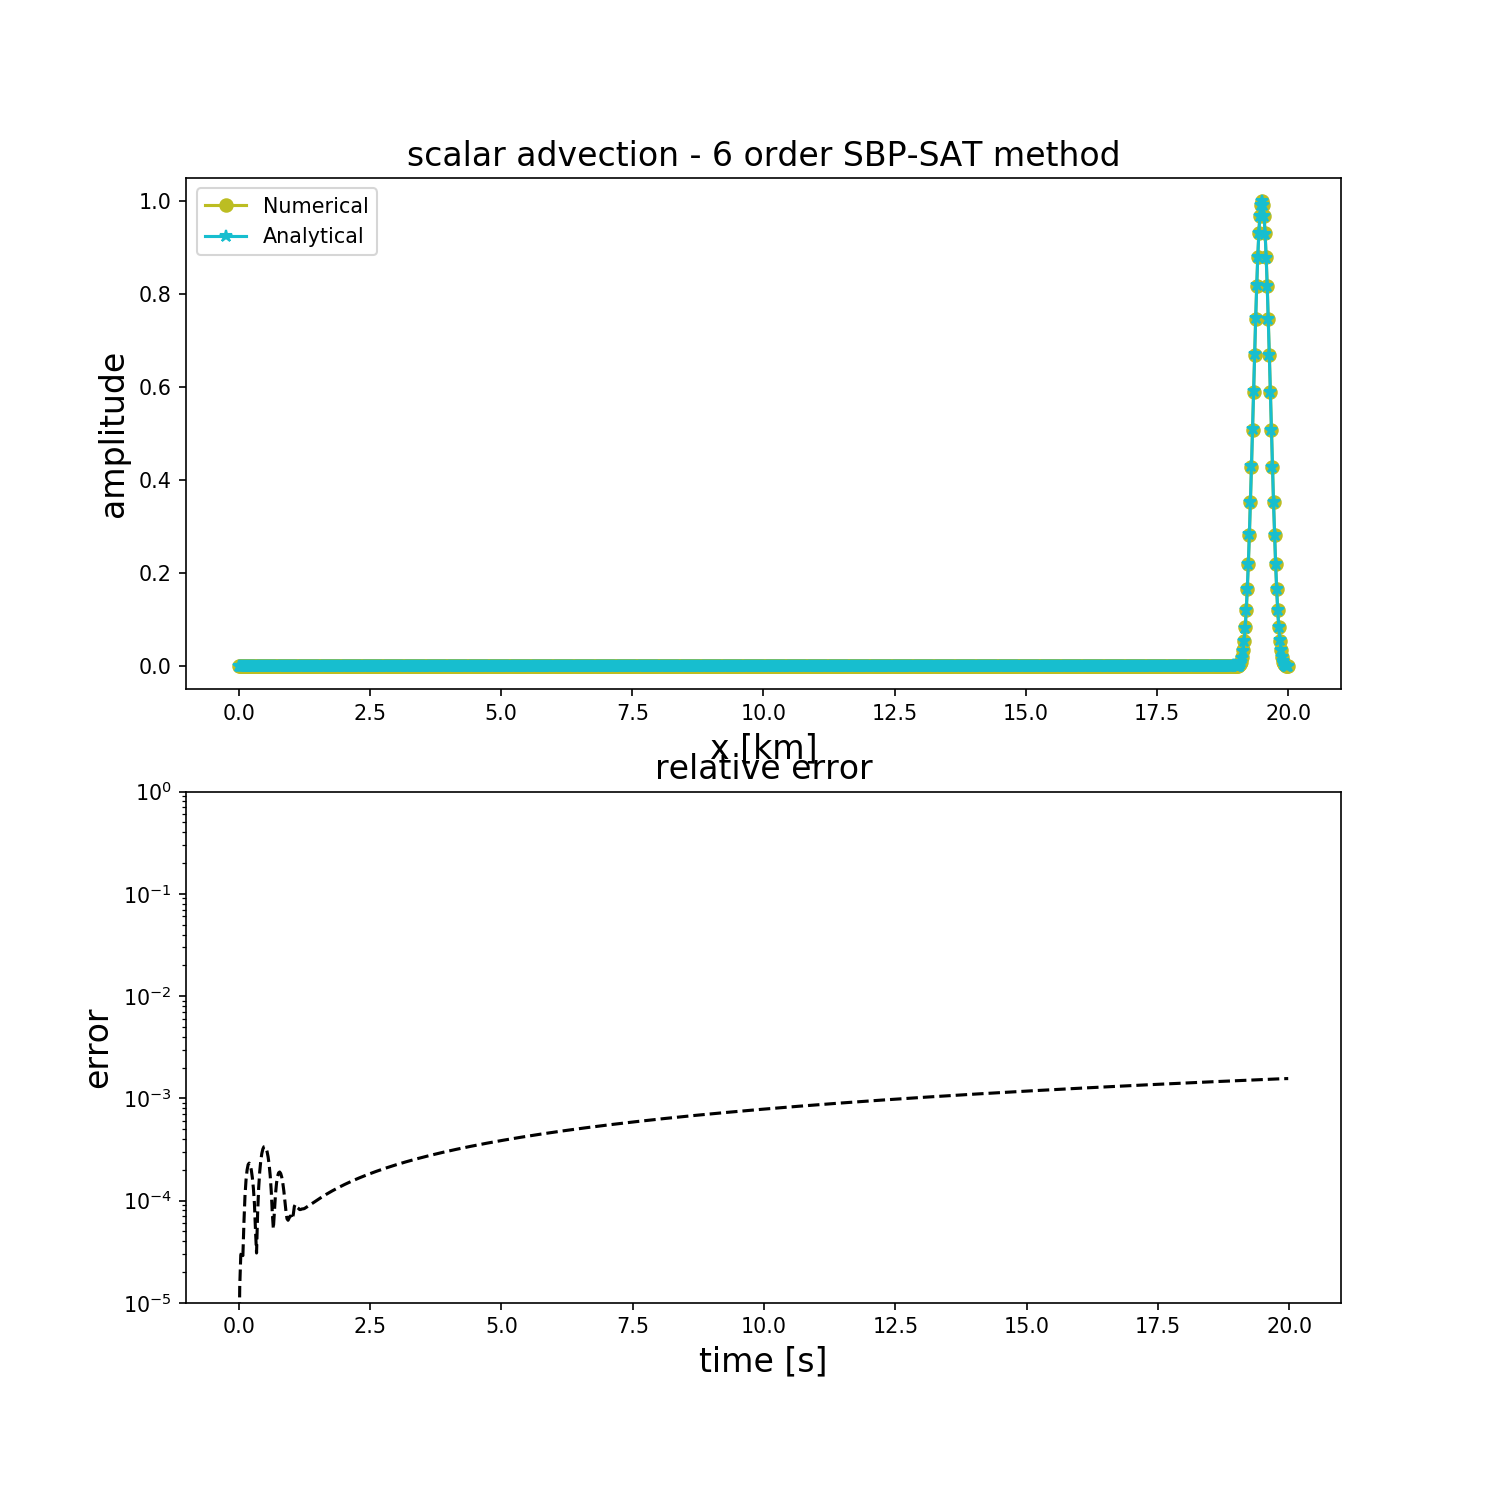

total simulation time =  58.99938888245032
spatial order  of accuracy =  6
number of grid points =  1001
maximum relative error =  0.00155955234781


In [3]:
# Plotting the simulation
# Initialize animated plot 
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(2,1,1)
line1 = ax1.plot(y, V, 'r', y, v, 'k--', lw=1.5)
plt.title('scalar advection - %s order SBP-SAT method'%order, size=16)
plt.xlabel('x [km]', size=16)
plt.ylabel('amplitude', size=16)


# Initialize relative error plot 
ax2 = fig1.add_subplot(2,1,2)
line2 = ax2.plot(T, EV, 'r', lw=1.5)
plt.title('relative error', size=16)
plt.xlabel('time [s]', size=16)
ax2.set_ylim([10**-5, 1])
plt.ylabel('error', size=16)

plt.ion()         # set interective mode
plt.show()



# Loop through time and evolve the wave-fields using ADER time-stepping scheme of N+1 order of accuracy
start = timeit.default_timer()

for j in range(0, nx):
        
        rate.g(V0, (5)-y[j,:])
        V[j, :] = V0
        
A =  (np.linalg.norm(V)) 

for t in utils.drange (0.0, tend,dt):
    n = n+1
    
    # compute numerical solution 
    time_integrator.RK4advection(v, v, nx, dx, order, y, t, dt, tau)
    
 
    for j in range(0, nx):
        
        rate.g(V0, (t+dt)-y[j,:])
        V[j, :] = V0
        
    T.append(t)
    
    EV.append(np.linalg.norm(V-v))

    # Updating plots
    if n % iplot == 0: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        

        # Display lines
        line1 = ax1.plot(y, V, '-o',y, v, '-*', lw=1.5)
        ax1.legend(iter(line1),('Numerical', 'Analytical'))
        line2 = ax2.plot(T, EV/A, 'k--', lw=1.5)
        ax2.set_yscale("log")#, nonposx='clip')               
        #
        # Display lines
        #line = plt.plot(y, V, '-o',y, v, '-*', lw=1.5)
        #plt.legend(iter(line), ('Analytic', 'FD'))
        #line3 = ax3.plot(T, EU, 'k--')
        #ax3.set_yscale("log", nonposx='clip')
        plt.gcf().canvas.draw()     
       
plt.ioff()
plt.show()

# Simulation end time
stop = timeit.default_timer()
print('total simulation time = ', stop - start)           # print the time required for simulation
print('spatial order  of accuracy = ', order)             # print the polynomial degree used
print('number of grid points = ', nx)                     # print the degree of freedom
print('maximum relative error = ', max(EV)/A)             # max. relative error in V

